In [1]:
import os

import torch
from torch.utils.data import Dataset
import cv2


class SouthParkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.paths = []
        for dir, subdir, files in os.walk(self.root_dir):
            for file in files:
                self.paths.append(os.path.join(dir, file))

    @staticmethod
    def __read_img(path) -> torch.Tensor:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        return image
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.__read_img(self.paths[idx])

        if self.transform:
            image = self.transform(image)

        return image

In [2]:
dataset = SouthParkDataset(root_dir="../single_character_data", transform=None)
len(dataset)

906

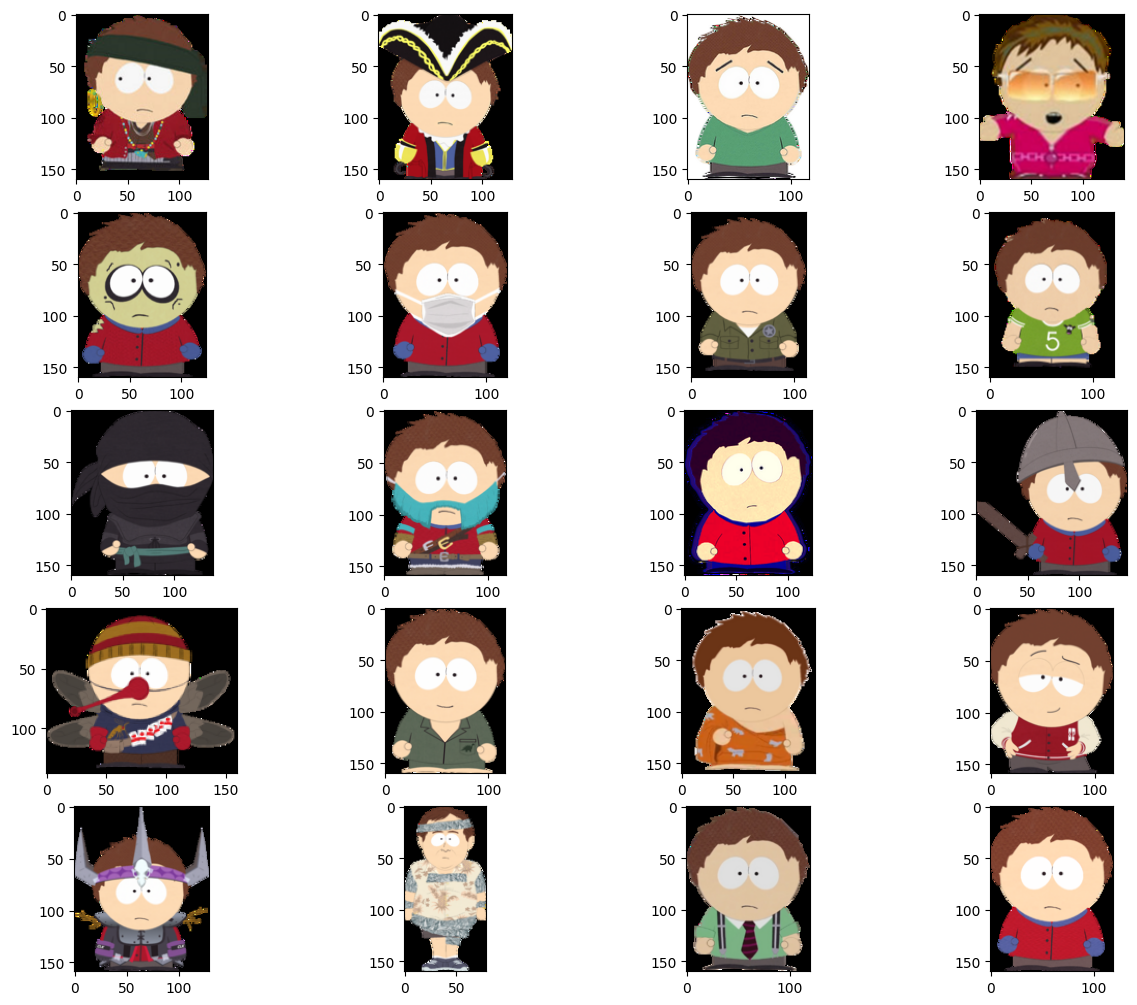

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)



show_images(dataset)

In [4]:
import torch.nn.functional as F

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 16


def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    dataset = SouthParkDataset(root_dir="../single_character_data", transform=data_transforms)
    
    return dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
        
    plt.imshow(reverse_transforms(image))

    
train_dataset = load_transformed_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/Users/user/PycharmProjects/south-park-character-generation/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


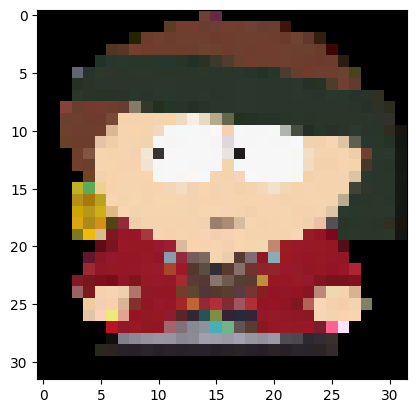

In [6]:
show_tensor_image(train_dataset[0])

In [7]:
!git clone https://github.com/openai/improved-diffusion
!mv improved-diffusion/improved_diffusion ./

fatal: destination path 'improved-diffusion' already exists and is not an empty directory.
mv: improved-diffusion/improved_diffusion: No such file or directory


In [8]:
! pip install -e improved-diffusion

Obtaining file:///Users/user/PycharmProjects/south-park-character-generation/improved-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: improved-diffusion
    Found existing installation: improved-diffusion 0.0.0
    Uninstalling improved-diffusion-0.0.0:
      Successfully uninstalled improved-diffusion-0.0.0
  Running setup.py develop for improved-diffusion

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [9]:
from improved_diffusion.unet import UNetModel

model = UNetModel(
    in_channels=3, 
    model_channels=64, 
    out_channels=3,
    num_res_blocks=3, 
    attention_resolutions=("16",)
)
model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-3): 3 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection

# Ну вот вроде как наш лосс 

<img src="https://latex.codecogs.com/gif.latex?x_t = t * x_1 + (1 - t) * x_0" /> 
</br>
Лосс
<img src="https://latex.codecogs.com/gif.latex?||f_{\theta }(x_t, t) - (x_1 - x_0)|| ^ 2" /> 

In [10]:
def get_loss(model, x_0, x_1, t):
    t = t.unsqueeze(1).unsqueeze(1).unsqueeze(1)
    x_t = t * x_1 + (1 - t) * x_0
    t = t.flatten()
    noise_pred = model(x_t, t)
    
    return F.mse_loss(noise_pred, (x_1 - x_0), reduction="sum")

In [11]:
def euler_integration(net, x0):
    model.eval()
    
    eps = 1e-8
    n_steps = 100
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(x0.device)

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(n_steps / num_images)

    for i in range(1, len(t)):
        with torch.no_grad():
            t_prev = t[i - 1].unsqueeze(0)
#             print(x0.shape, t_prev.shape)
            f_eval = net(x0, t_prev)
        x = x0 + (t[i] - t[i - 1]) * f_eval
        x0 = x
        
        if i % stepsize == 0 or i == (len(t) - 1):
            plt.subplot(1, num_images, int(i / stepsize))
            show_tensor_image(x.detach().cpu())
    plt.show()
    return x

In [12]:
def train_epoch(model, dataloader, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        t = torch.tensor(np.random.uniform(size=(BATCH_SIZE)), dtype=torch.float32).to(device)

        x_1 = batch.to(device)
        x_0 = torch.tensor(np.random.normal(size=list(x_1.size())), dtype=torch.float32).to(device)
        
        loss = get_loss(model, x_0, x_1, t)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader.dataset)

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 2935.452978407837


/var/folders/l3/l0vfq_n54s9d8739l34r9qv00000gn/T/ipykernel_37627/2784597103.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i / stepsize))


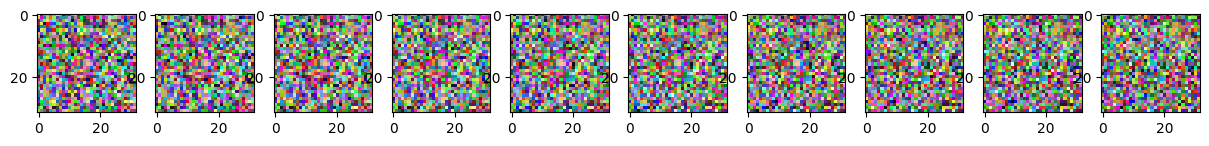

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 2181.4000845060705


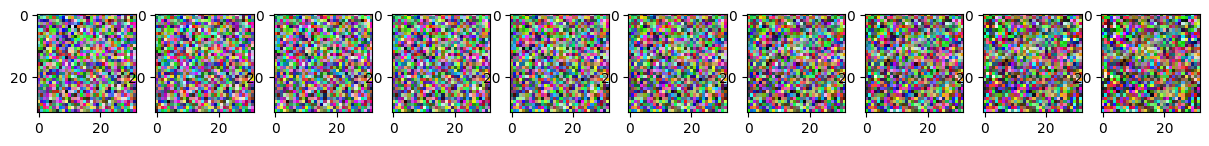

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1716.590042080574


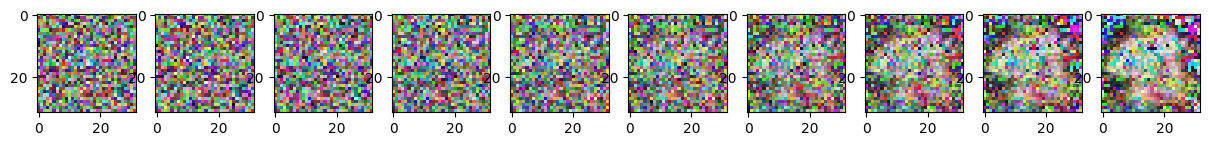

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1513.170958798979


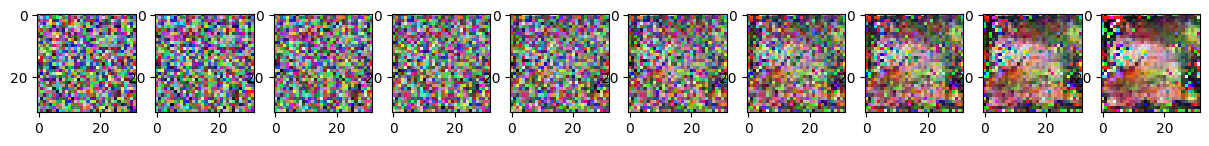

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 1368.638016521799


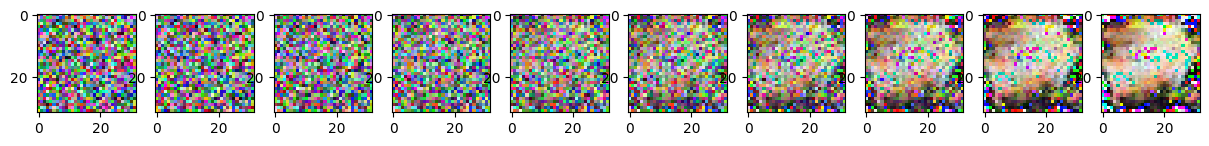

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 1324.0024090697434


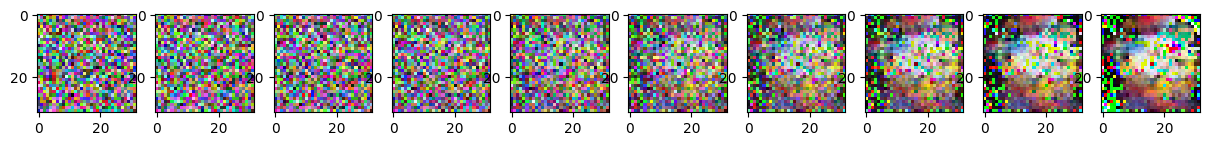

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 1265.9257898730684


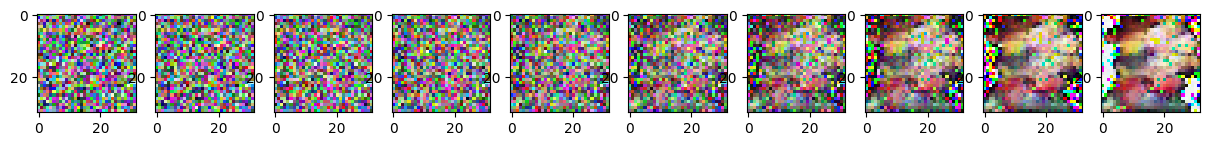

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 1284.7545486685983


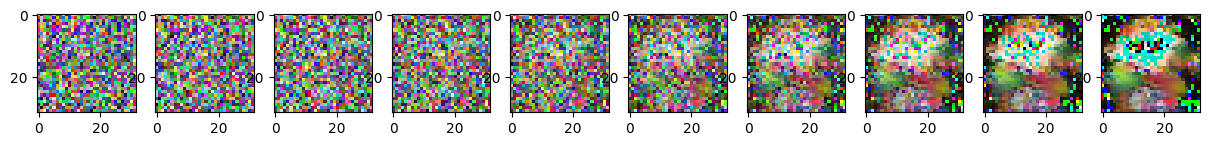

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 1200.212233116032


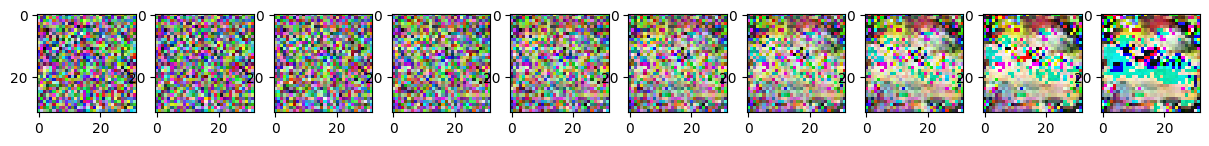

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 1190.1174321795668


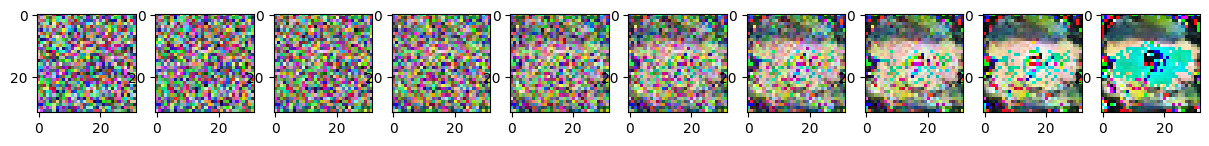

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1144.4305174703366


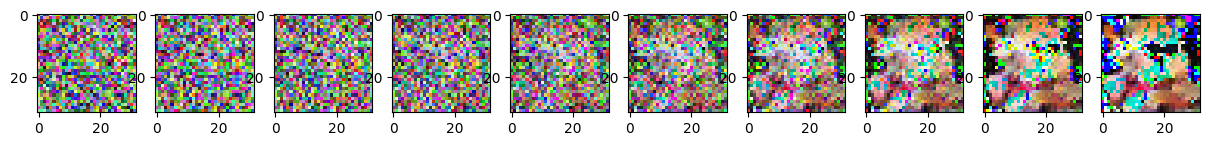

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 1144.3064627742135


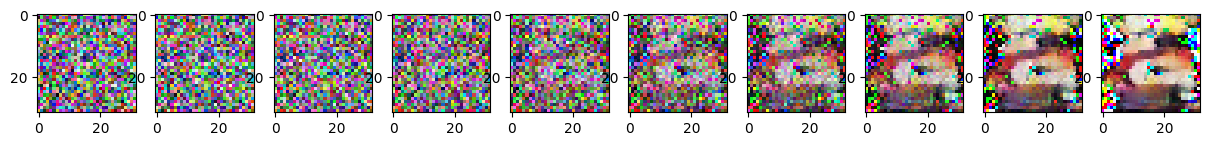

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 1113.8853401369342


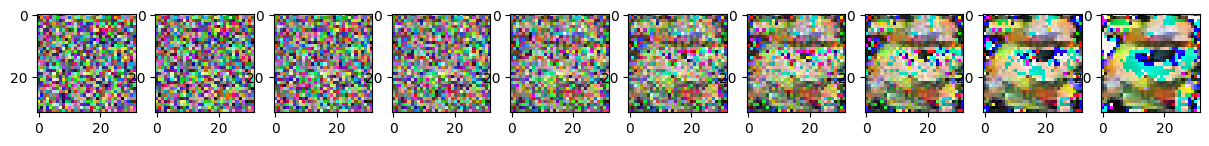

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 1079.6794201848786


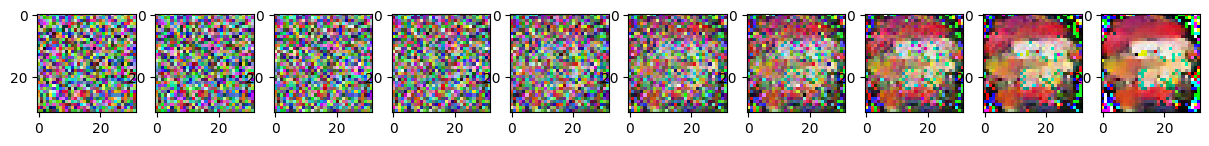

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 1081.5253841576987


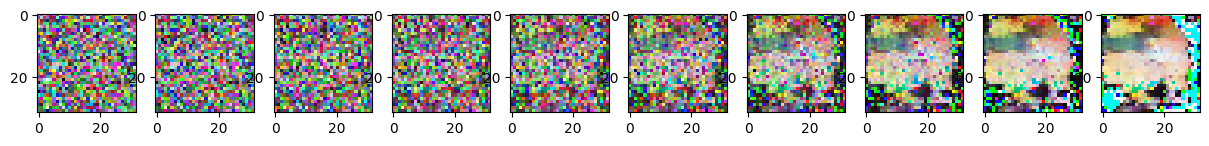

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 1083.0949292046082


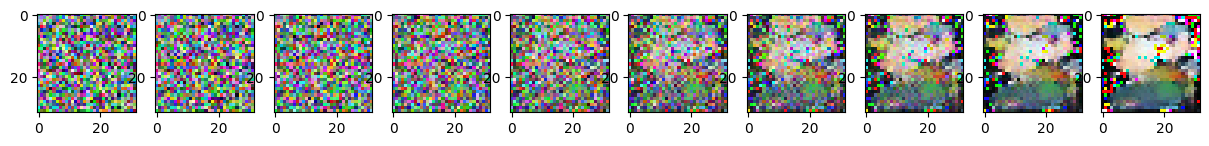

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 1085.585811387624


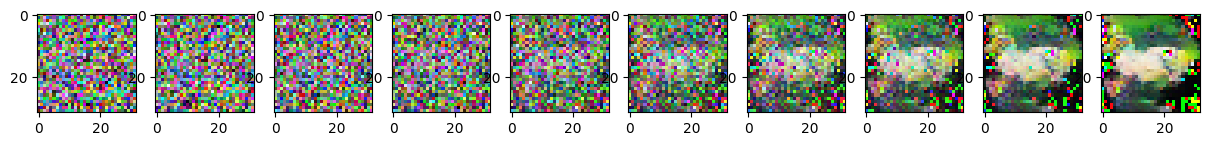

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 1051.32146799117


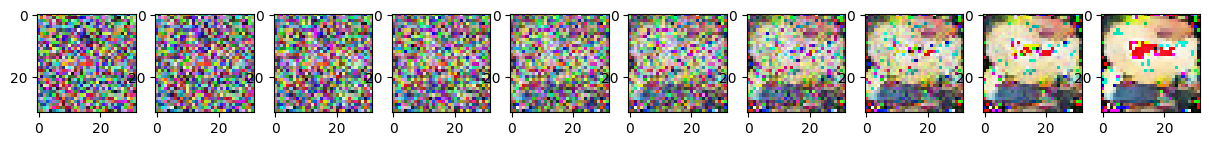

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 1045.747537036079


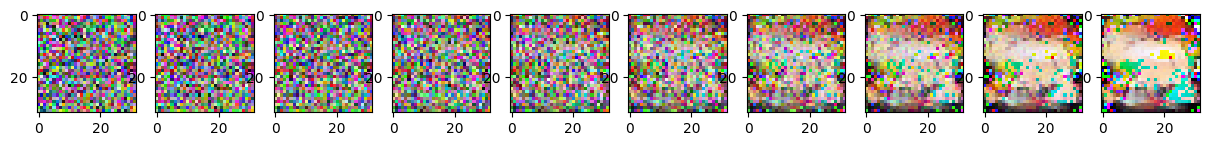

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 1000.0289023696192


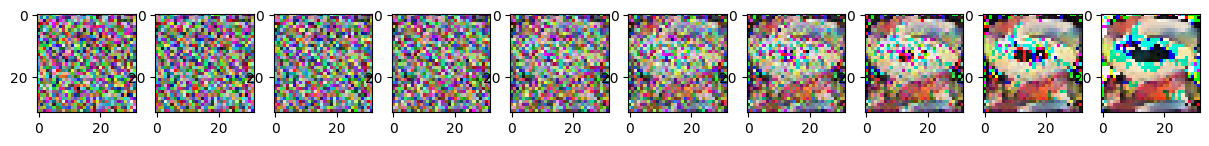

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 1026.1326109357753


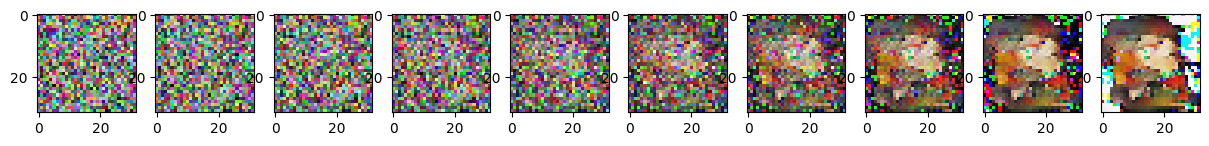

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 999.2455278611341


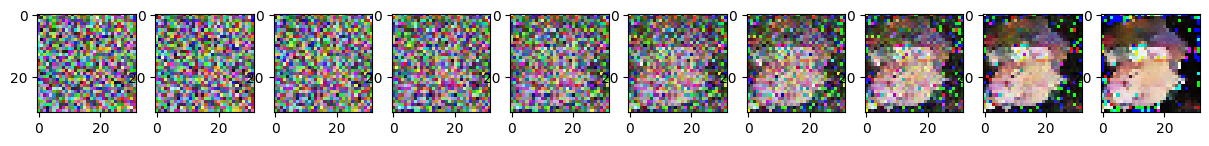

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 995.4219914114238


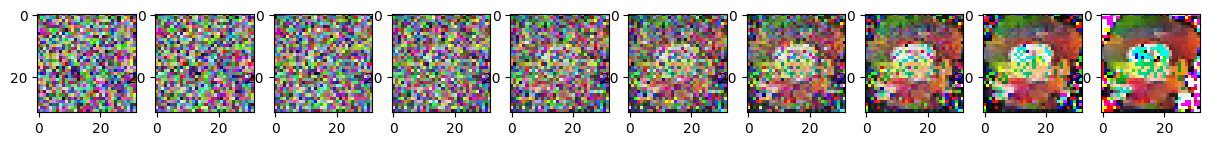

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 990.9886110823676


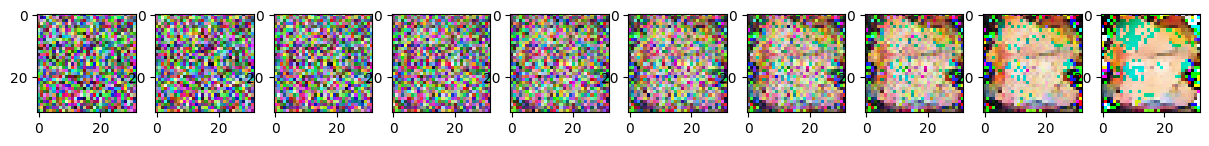

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 1006.7263458454056


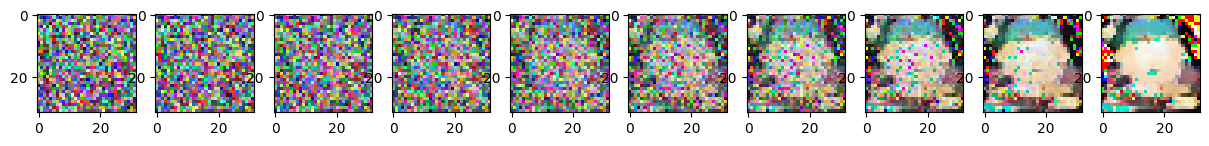

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 953.9186930877484


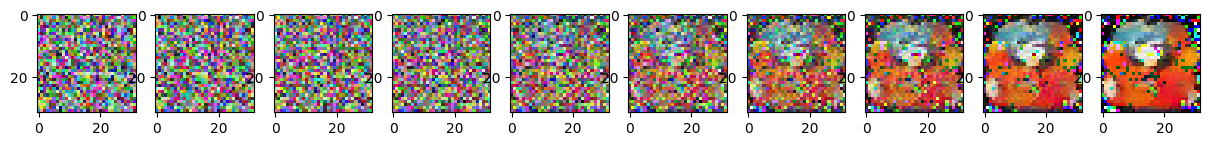

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 969.4713142849752


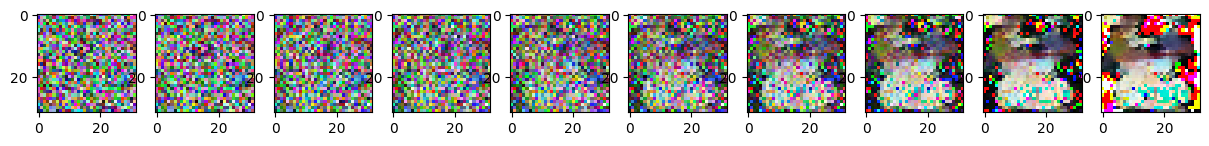

  0%|          | 0/56 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
from torch.optim import Adam
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 100 # Try more!

for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, device)
    # eval_loss = eval_epoch(model, test_dataloader, device)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss}")
        
        euler_integration(model, torch.tensor(np.random.normal(size=[3, 32, 32]), dtype=torch.float32).to(device).unsqueeze(0))

# Sampling

In [ ]:
import torch
model = torch.load("impaining_model_5.pt")
device = "cuda"
model.to(device)
model

100%|██████████| 1000/1000 [00:26<00:00, 38.14it/s]


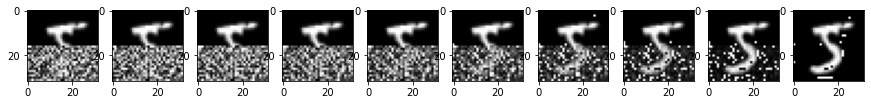

100%|██████████| 1000/1000 [00:25<00:00, 38.64it/s]


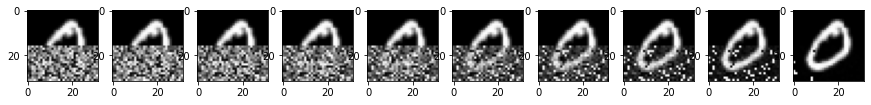

100%|██████████| 1000/1000 [00:25<00:00, 39.94it/s]


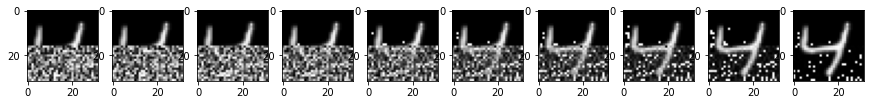

100%|██████████| 1000/1000 [00:25<00:00, 39.38it/s]


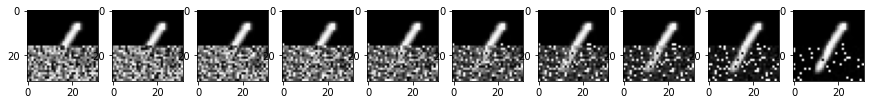

100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s]


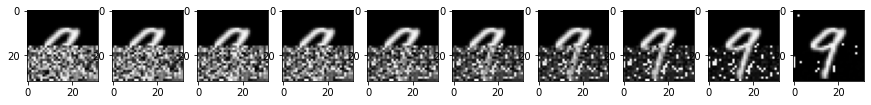

100%|██████████| 1000/1000 [00:25<00:00, 39.01it/s]


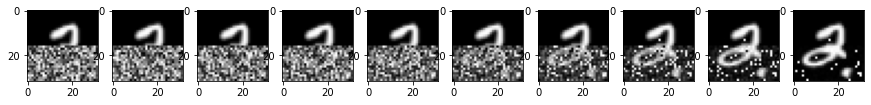

100%|██████████| 1000/1000 [00:26<00:00, 38.37it/s]


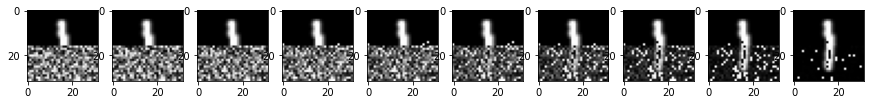

100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]


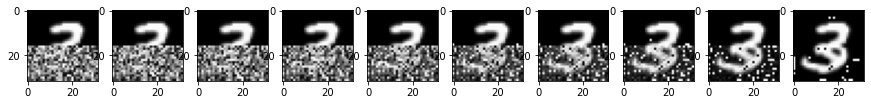

100%|██████████| 1000/1000 [00:24<00:00, 40.11it/s]


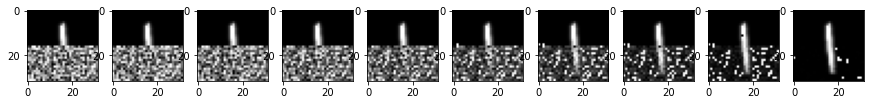

100%|██████████| 1000/1000 [00:25<00:00, 39.59it/s]


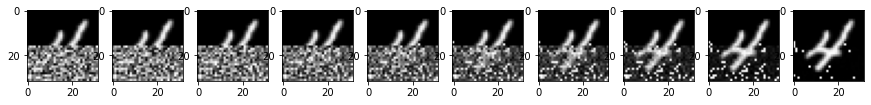

100%|██████████| 1000/1000 [00:25<00:00, 38.71it/s]


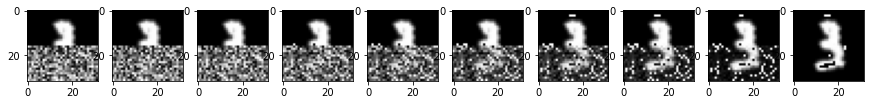

100%|██████████| 1000/1000 [00:25<00:00, 38.69it/s]


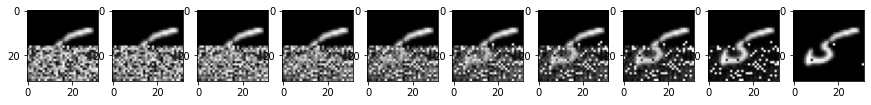

100%|██████████| 1000/1000 [00:25<00:00, 38.50it/s]


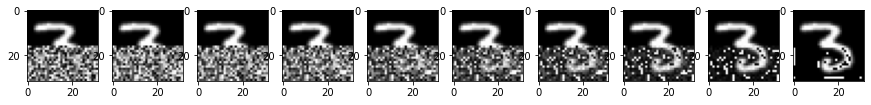

100%|██████████| 1000/1000 [00:24<00:00, 40.03it/s]


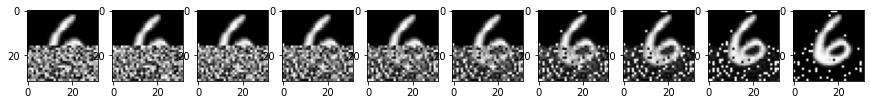

100%|██████████| 1000/1000 [00:25<00:00, 38.62it/s]


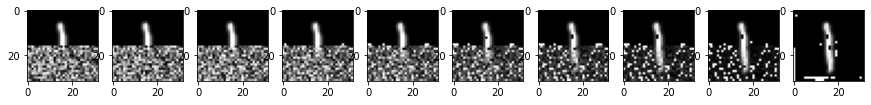

100%|██████████| 1000/1000 [00:25<00:00, 39.28it/s]


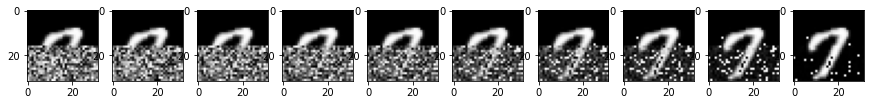

100%|██████████| 1000/1000 [00:25<00:00, 39.88it/s]


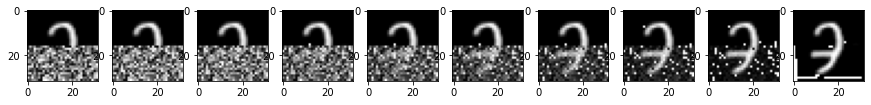

100%|██████████| 1000/1000 [00:25<00:00, 38.88it/s]


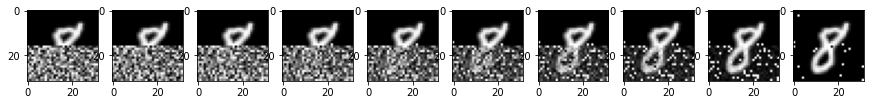

100%|██████████| 1000/1000 [00:25<00:00, 39.13it/s]


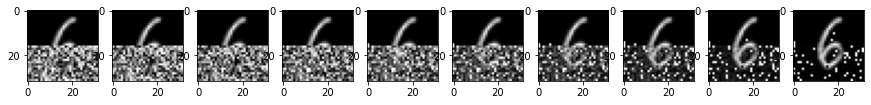

100%|██████████| 1000/1000 [00:25<00:00, 38.69it/s]


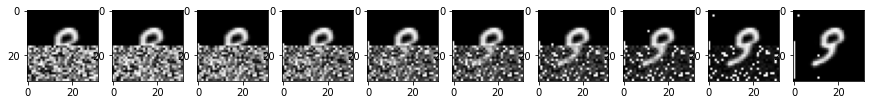

In [13]:
from tqdm import tqdm

for i in range(20):
    euler_integration(model, destroy_bottom(dataset[i][0].to("cuda").unsqueeze(0)))